# Data Ingest

Access data stored on s3 and explore with Athena

In [33]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

Set up sagemaker instance

In [34]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

Verify objects in public bucket

In [35]:
!aws s3 ls s3://ads-508-final/playstation/

                           PRE achievements/
                           PRE games/
                           PRE history/
                           PRE players/
                           PRE prices/
                           PRE purchased_games/


In [36]:
# set path for public bucket
s3_playstation_path_public = 's3://ads-508-final/playstation/'

In [37]:
# set staging directory in private bucket
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [38]:
# create connection with pyathena
# EXPLORE USING ENGINE
conn = connect(region_name = region, s3_staging_dir = s3_staging_dir)

In [39]:
# define database name
database_name = "playstationaws"

In [40]:
# create database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement) 

CREATE DATABASE IF NOT EXISTS playstationaws


In [41]:
# execute query to create database
pd.read_sql(statement, conn)

""


In [60]:
# execute query to show database is present
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,default
1,playstationaws


## Fix the underlying data

The datafix notebook properly overwrites data to account for JSON arrays in the csv files

## Load data into Athena tables for analysis

Confirm process and load with `games` data, then iterate through and create remaining tables

In [43]:
# define table names based on datasets
table_names = ['achievements', 'games', 'history', 'players', 'prices', 'purchased_games']

In [92]:
# drop tables if needed
for name in table_names:
    pd.read_sql("""DROP TABLE IF EXISTS {}.{};""".format(database_name, name), conn)

In [93]:
# create table for games data
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS playstationaws.games (
                    game_id STRING,
                    title STRING,
                    platform STRING,
                    developers STRING,
                    publishers STRING,
                    genres STRING,
                    supported_languages STRING,
                    release_date STRING
                )
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
                WITH SERDEPROPERTIES (
                    "separatorChar" = ",",
                    "quoteChar" = "\\""
                )
                LOCATION 's3://ads-508-final/playstation/games/'
                TBLPROPERTIES ('skip.header.line.count'='1', 'compressionType'='gzip');"""

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS playstationaws.games (
                    game_id STRING,
                    title STRING,
                    platform STRING,
                    developers STRING,
                    publishers STRING,
                    genres STRING,
                    supported_languages STRING,
                    release_date STRING
                )
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
                WITH SERDEPROPERTIES (
                    "separatorChar" = ",",
                    "quoteChar" = "\""
                )
                LOCATION 's3://ads-508-final/playstation/games/'
                TBLPROPERTIES ('skip.header.line.count'='1', 'compressionType'='gzip');


In [94]:
# execute query to create table and load data
pd.read_sql(statement, conn)

""


In [95]:
# define query and check load
statement = """select * from {}.games limit 50""".format(database_name)

In [96]:
df = pd.read_sql(statement, conn)

,game_id,title,platform,developers,publishers,genres,supported_languages,release_date
0,749375,Medieval Match Master,PS4,['Erik Games'],['Erik Games'],['Puzzle'],,2024-11-22
1,749839,Sunforge Solar Survival,PS4,['GrizzlyGames'],['GrizzlyGames'],,,2024-11-21
2,749347,Find Love Or Die Trying,PS5,['Sunseeker Games'],['Ratalaika Games'],['Visual Novel'],,2024-11-22
3,749341,Medieval Match Master,PS4,['Erik Games'],['Erik Games'],['Puzzle'],,2024-11-22
4,749097,Bust A Block 2,PS5,['ThiGames'],['ThiGames'],['Puzzle'],,2024-11-21
5,749095,Bust A Block 2,PS4,['ThiGames'],['ThiGames'],['Puzzle'],,2024-11-21
6,746306,Trading Card Shop Simulator,PS5,['NOSTRA GAMES'],['NOSTRA GAMES'],['Simulation'],,2024-11-14
7,746215,Trading Card Shop Simulator,PS5,['NOSTRA GAMES'],['NOSTRA GAMES'],['Simulation'],,2024-11-14
8,745840,Sprawl,PS5,['MAETH'],['Rogue Games'],['First Person Shooter'],,2024-11-21
9,746216,Trading Card Shop Simulator,PS4,['NOSTRA GAMES'],['NOSTRA GAMES'],['Simulation'],,2024-11-14


In [122]:
tables = []

In [123]:
# create table for achievements data
statement_ach = """create external table if not exists {}.{} (
            achievementid string,
            gameid string,
            title string,
            description string,
            rarity string
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}achievements/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[0], s3_playstation_path_public
        )

tables.append(statement_ach)

In [124]:
# create table for history data
statement_hist = """create external table if not exists {}.{} (
            playerid string,
            achievementid string,
            date_acquired date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}history/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[2], s3_playstation_path_public
        )

tables.append(statement_hist)

In [125]:
# create table for players data
statement_pla = """create external table if not exists {}.{} (
            playerid string,
            nickname string,
            country string
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}players/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[3], s3_playstation_path_public
        )

tables.append(statement_pla)

In [126]:
# create table for prices data
statement_pri = """create external table if not exists {}.{} (
            gameid string,
            usd int,
            eur int,
            gbp int,
            jpy int,
            rub int,
            date_acquired date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}prices/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[4], s3_playstation_path_public
        )

tables.append(statement_pri)

In [127]:
# create table for purchased_games data
statement_pur = """create external table if not exists playstationaws.purchased_games (
            playerid string,
            library string
            )
            ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
                    WITH SERDEPROPERTIES (
                        "separatorChar" = ",",
                        "quoteChar" = "\\""
            )
            LOCATION 's3://ads-508-final/playstation/purchased_games/'
            TBLPROPERTIES ('skip.header.line.count'='1', 'compressionType'='gzip');"""

tables.append(statement_pur)

In [128]:
for statement in tables:
    pd.read_sql(statement, conn)
    print(f"creating table {statement}...")

creating table create external table if not exists playstationaws.achievements (
            achievementid string,
            gameid string,
            title string,
            description string,
            rarity string
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\n'
        location 's3://ads-508-final/playstation/achievements/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');...
creating table create external table if not exists playstationaws.history (
            playerid string,
            achievementid string,
            date_acquired date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\n'
        location 's3://ads-508-final/playstation/history/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');...
creating table create external table if not exists playstationaws.players (
            playerid string,


In [129]:
statement = """select * from {}.purchased_games limit 10""".format(database_name)
df = pd.read_sql(statement, conn)
df

,playerid,library
0,1360470,"[619583, 439796, 582629, 550305, 553947, 18187..."
1,4304121,"[417808, 572209, 420981, 619584, 619583, 7248,..."
2,2136972,"[643858, 330335, 430192, 15945, 666513, 181873..."
3,296504,"[697036, 747745, 670871, 677280, 743853, 74395..."
4,2409067,"[749376, 721802, 716567, 692281, 572363, 52951..."
5,398674,"[706747, 550305, 747890, 706748, 550307, 73347..."
6,323975,"[550305, 480778, 717242, 463264, 637403, 41780..."
7,4156646,"[437991, 184878, 141933, 160171, 7248, 5628, 1..."
8,293830,"[447655, 20124, 18929, 11739, 168465, 6067, 82..."
9,3636123,"[726773, 702561, 706550, 702257, 613827, 41815..."


## Data exploration and visualization

Explore tables in our database

#### Apply initial formatting for visualizations

In [130]:
sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

In [131]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

### Games

#### What are the top 25 genres by volume in the game categlog on Playstation?

In [139]:
statement = """select genres, count(*) as total
    from {}.games
    group by genres
    order by total desc
    limit 25
""".format(database_name)

df_genre = pd.read_sql(statement, conn)
df_genre

,genres,total
0,['Action'],3031
1,['Platformer'],1858
2,['Puzzle'],1850
3,['Indie'],1389
4,['Adventure'],1320
5,"[""Shoot 'em up""]",1142
6,['Visual Novel'],703
7,['Simulation'],649
8,['Action-Adventure'],625
9,['strategy'],467


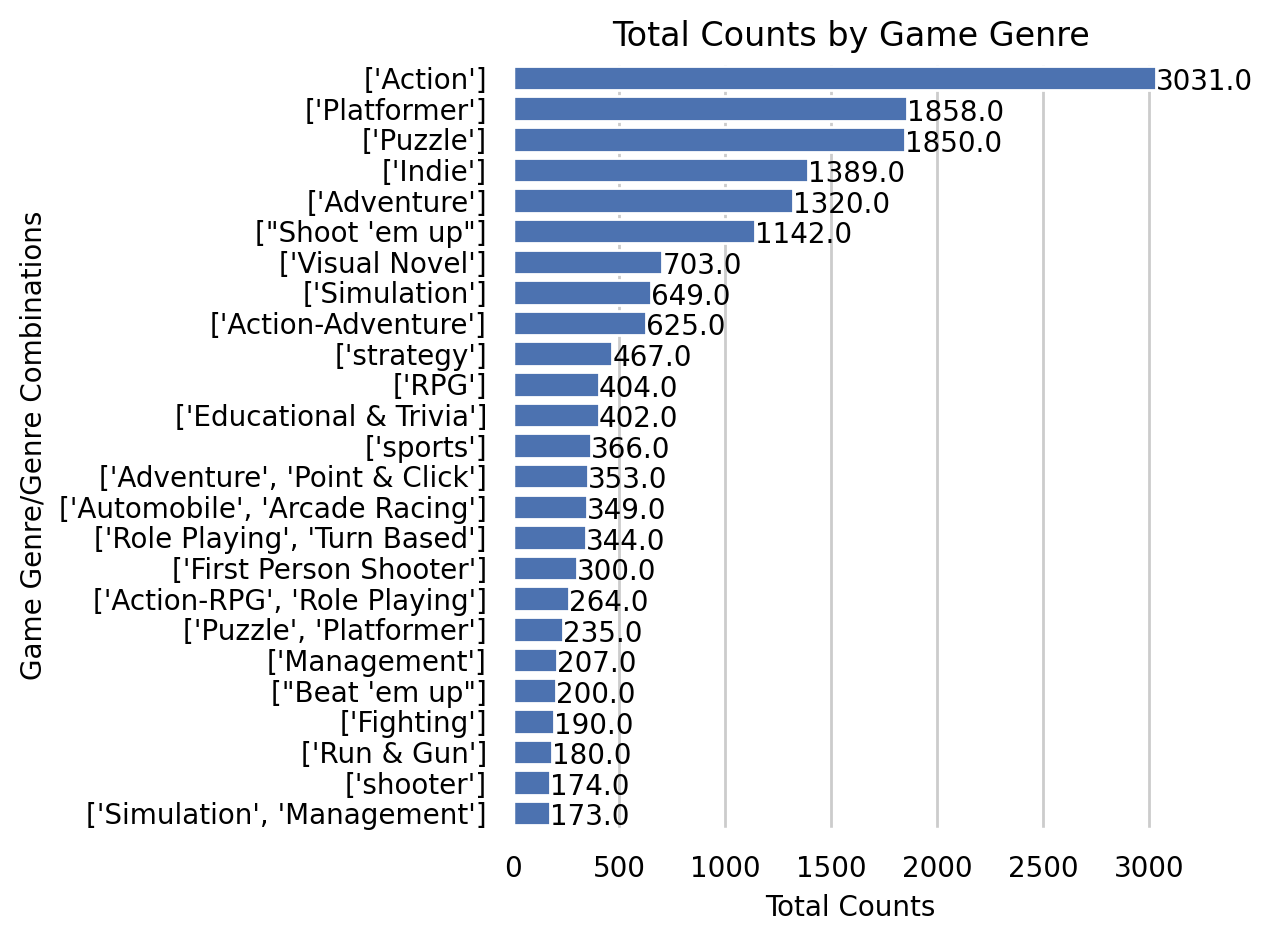

In [172]:
barplot = sns.barplot(y="genres", x="total", data=df_genre, saturation=1)

# Set title and x-axis ticks
plt.title("Total Counts by Game Genre")

# Helper code to show actual values afters bars
show_values_barplot(barplot, 0.1)

plt.xlabel("Total Counts")
plt.ylabel("Game Genre/Combinations")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

#### How many Indie games were made each year? 

### Purchased Games

In [178]:
statement = """select 
            EXTRACT(year FROM CAST(release_date AS date)) AS year,
            COUNT(*) AS total
            FROM {}.games
            WHERE genres like '%Indie%'
            GROUP BY EXTRACT(year FROM CAST(release_date AS date))
            ORDER BY year
""".format(database_name)

df_indie = pd.read_sql(statement, conn)
df_indie

,year,total
0,2009,4
1,2010,5
2,2011,9
3,2012,8
4,2013,26
5,2014,29
6,2015,35
7,2016,125
8,2017,202
9,2018,270


[03/18/25 04:12:45] INFO     Using categorical units to plot a list of strings that are all         ]8;id=880813;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=781496;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=752122;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=177027;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

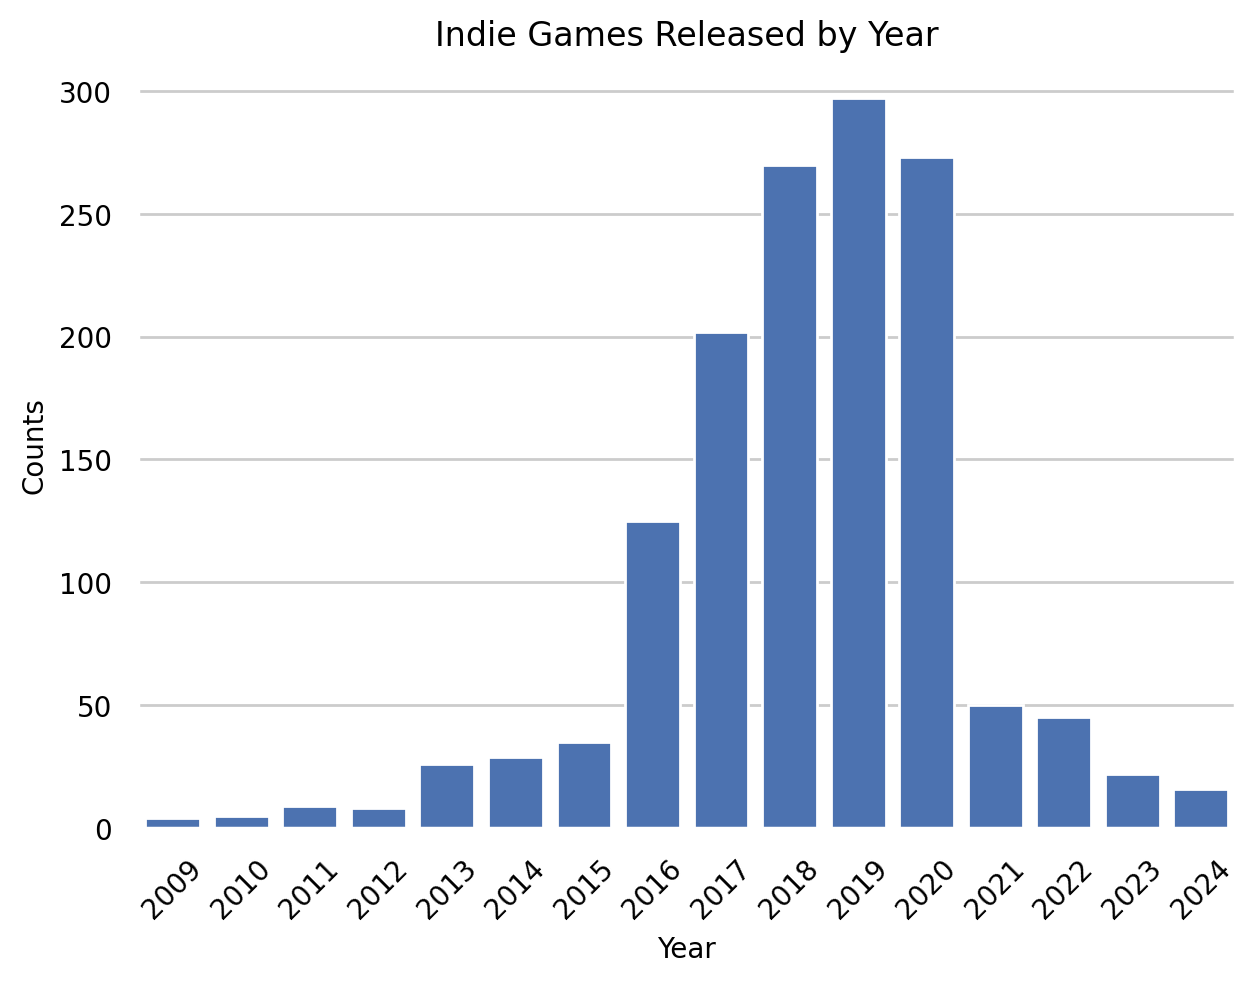

In [183]:
df_indie['year'] = pd.to_numeric(df_indie['year'], errors='coerce')
df_indie['total'] = pd.to_numeric(df_indie['total'], errors='coerce')


barplot = sns.barplot(x="year", y="total", data=df_indie, saturation=1)

# Set title and x-axis ticks
plt.title("Indie Games Released by Year")

plt.xlabel("Year")
plt.ylabel("Counts")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

plt.xticks(rotation=45)

# Show graphic
plt.show(barplot)